# Project Idea 1: 

- Make a simplifying assumption between the **loan issuance date** and application dates,
convert the approved loans into the formats of rejected loan applications.
- Use supervised technique and clustering, describe (reverse engineering) 
the loan approval criterion of **Lending Club**.

    - Challenges: The aggregated data has more than $20M$ samples. This is
        beyond the coverage of many ML algorithms. How do you design an apporach 
        which allows you to train on such a large size data? The problem is
        particularly serious for training **pooled** models.
    - When you apply supervised technique, it might involve imbalanced classification.
    How would you handle 'im-balanced dataset' like this?
    
- Are there poor performing approved loans which should be rejected?
- What is the business impact (pros and cons) of rejecting such non-performing loans?
</a><br>
# Structure: 
- <a href="#preprocessing">Preprocessing</a><br>
- <a href="#function">Function</a><br>
- <a href="#ml">Machine Learning</a><br>
    - <a href="#decision">Decision Tree</a><br>
    - <a href="#rf">Random Forest</a><br>
    - <a href="#svm">SVM</a><br>
    - <a href="#xgboost">XGBoost</a><br>

In [1]:
import numpy as np
import pandas as pd

pd.options.display.max_columns = None
pd.options.display.max_rows = 100

# from sklearn.preprocessing import OrdinalEncoder
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder

# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression 
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler 


In [ ]:
df_raw_accepted = pd.read_csv('accepted_2007_to_2018Q4.csv')
df_raw_rejected = pd.read_csv('rejected_2007_to_2018Q4.csv')

In [2]:
sample_accepted = pd.read_csv('sample_accepted.csv')
sample_rejected = pd.read_csv('sample_rejected.csv')

 <p><a name="preprocessing"></a></p>
 
 ## Preprocessing

In [73]:
rejected = sample_rejected.iloc[:,1:9]
rejected = rejected.rename(columns={"Amount Requested": "loan_amnt", "Application Date": "app_date", "Loan Title": "purpose",
                         "Risk_Score": "risk_score", "Debt-To-Income Ratio": "dti", "Zip Code": "zip_code",
                         "State": "addr_state", "Employment Length": "emp_length"})
rejected['loan_status'] = 0

rejected['purpose'] = rejected['purpose'].str.lower().replace(' ', '_')

rejected['app_date'] = pd.to_datetime(rejected['app_date'])
rejected['app_year'] = rejected['app_date'].dt.year
rejected['app_month'] = rejected['app_date'].dt.month

rejected['dti'] = rejected['dti'].str.replace('%','')

rejected = rejected.drop(columns = 'app_date')

In [59]:
accepted = sample_accepted[['loan_amnt', 'purpose', 'dti',
       'zip_code', 'addr_state', 'emp_length', 'issue_d',
       'loan_status', 'last_fico_range_high','last_fico_range_low']]

In [ ]:
accepted['issue_d'] = pd.to_datetime(accepted['issue_d'])
accepted['app_year'] = accepted['issue_d'].dt.year
accepted['app_month'] = accepted['issue_d'].dt.month

accepted['risk_score'] = (accepted['last_fico_range_high'] + accepted['last_fico_range_low'])/2
accepted = accepted.drop(columns = ['issue_d','last_fico_range_high','last_fico_range_low'])

accepted = accepted.replace({'loan_status' : { 'Charged Off' : 'rejected', 'Late (16-30 days)' : 'rejected', 
                                   'Late (31-120 days)' : 'rejected',
                                   'Does not meet the credit policy. Status:Charged Off' : 'rejected',
                                   'Fully Paid' : 'accepted', 'Current' : 'accepted',
                                   'In Grace Period' : 'accepted',
                                   'Does not meet the credit policy. Status:Fully Paid' : 'accepted'}})

In [61]:
df_processed = pd.concat([accepted, rejected], sort=True)

In [62]:
total = df_processed.isnull().sum().sort_values(ascending=False)
percent = (df_processed.isnull().sum()/df_processed.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
risk_score,2026,0.337667
emp_length,303,0.050500
dti,2,0.000333
zip_code,0,0.000000
purpose,0,0.000000
loan_status,0,0.000000
loan_amnt,0,0.000000
app_year,0,0.000000
app_month,0,0.000000
addr_state,0,0.000000


 <p><a name="function"></a></p>
 
 ## Function 

In [104]:
'''
For applications prior to November 5, 2013 the risk score is the borrower's FICO score. 
For applications after November 5, 2013 the risk score is the borrower's Vantage score.
'''

def data_process(accepted,rejected):
    
    accepted = sample_accepted.copy()
    rejected = sample_rejected.copy()
    
    # Processing accepted data 
    accepted = accepted[['loan_amnt', 'purpose', 'dti',
       'zip_code', 'addr_state', 'emp_length', 'issue_d',
       'loan_status', 'last_fico_range_high','last_fico_range_low']]
    
    accepted['issue_d'] = pd.to_datetime(accepted['issue_d'])
    accepted['app_year'] = accepted['issue_d'].dt.year
    accepted['app_month'] = accepted['issue_d'].dt.month

    accepted['risk_score'] = (accepted['last_fico_range_high'] + accepted['last_fico_range_low'])/2
    accepted = accepted.drop(columns = ['issue_d','last_fico_range_high','last_fico_range_low'])

#     if reverse = False:
#         accepted = accepted.replace({'loan_status' : { 'Charged Off' : 'rejected', 'Late (16-30 days)' : 'rejected', 
#                                        'Late (31-120 days)' : 'rejected',
#                                        'Does not meet the credit policy. Status:Charged Off' : 'rejected',
#                                        'Fully Paid' : 'accepted', 'Current' : 'accepted',
#                                        'In Grace Period' : 'accepted',
#                                        'Does not meet the credit policy. Status:Fully Paid' : 'accepted'}})

    accepted['loan_status'] =1
            
    
    # Processing rejected data 
    rejected = rejected.iloc[:,1:9]
    rejected = rejected.rename(columns={"Amount Requested": "loan_amnt", "Application Date": "app_date", "Loan Title": "purpose",
                             "Risk_Score": "risk_score", "Debt-To-Income Ratio": "dti", "Zip Code": "zip_code",
                             "State": "addr_state", "Employment Length": "emp_length"})
    rejected['loan_status'] = 0
    
    rejected['purpose'] = rejected['purpose'].str.lower().replace(' ','other')
    rejected = rejected.replace({'purpose' : { 'debt consolidation' : 'debt_consolidation', 'debt' : 'debt_consolidation', 
                               'credit' : 'credit_card',
                               'business' : 'small_business',
                               'home' : 'house', 'medical expenses' : 'medical',
                               'home improvement' : 'home_improvement',
                               'renewable' : 'renewable_energy',
                               'car financing' : 'car',
                               'credit card refinancing' : 'credit_card',
                               'small' : 'small_business', 'major purchase' : 'major_purchase',
                               'moving and relocation' : 'moving',
                               'business loan' : 'small_business',              
                               'home buying' : 'major_purchase',
                               'major' : 'credit_card',
                               'green loan' : 'renewable_energy', 'business loan expansion' : 'small_business',
                               'mmurov12' : 'other',
                               'holiday purchases' : 'other',
                               'buying costumes for my store' : 'small_business',              
                               'home buying' : 'major_purchase',
                               'my loan' : 'debt_consolidation',
                               'trying to get out of high interest rates' : 'debt_consolidation', 'lower my cc debt' : 'credit_card',
                               'motorcycle' : 'car',
                               'pay off debt' : 'debt_consolidation',
                               'student loan' : 'other', 'debt free' : 'debt_consolidation',
                               'motorcycle' : 'car',
                               'to fill up store with groceries' : 'small_business', 'pay off debt ' : 'debt_consolidation'
                                             }})

    rejected['app_date'] = pd.to_datetime(rejected['app_date'])
    rejected['app_year'] = rejected['app_date'].dt.year
    rejected['app_month'] = rejected['app_date'].dt.month

    rejected = rejected.drop(columns = 'app_date')
    
    rejected['dti'] = rejected['dti'].str.replace('%','')
    
    # Merge accepted and rejected data for later process
    df_processed = pd.concat([accepted, rejected], sort=True)
    

    # Convert categorical to numerical-- 10 means more than 10 years 
    df_processed['emp_length'] = df_processed['emp_length'].str.extract('(\d+)')


    # Missing Values: risk_score, emp_length, dti
    df_processed['emp_length'] = df_processed['emp_length'].fillna(0)
    df_processed['emp_length'] = df_processed['emp_length'].astype(int)
    df_processed['risk_score'] = df_processed['risk_score'].fillna(0)
    df_processed['dti'] = df_processed['dti'].fillna(0)
    df_processed['dti'] = df_processed['dti'].astype(float)
    
    df_processed = pd.get_dummies(df_processed)
    
    return df_processed

In [105]:
df_processed = data_process(sample_accepted,sample_rejected)

In [106]:
df_processed

,addr_state,app_month,app_year,dti,emp_length,loan_amnt,loan_status,purpose,risk_score,zip_code
0,CA,9,2015,29.72,10,33550.0,1,credit_card,727.0,952xx
1,FL,12,2016,23.20,2,8700.0,1,debt_consolidation,692.0,338xx
2,OH,5,2018,16.61,0,30000.0,1,credit_card,697.0,450xx
3,CA,10,2018,22.89,1,30000.0,1,debt_consolidation,757.0,913xx
4,PA,10,2015,21.18,8,15000.0,1,debt_consolidation,702.0,180xx
...,...,...,...,...,...,...,...,...,...,...
2995,PA,9,2015,51.24,1,10000.0,0,debt_consolidation,0.0,150xx
2996,FL,7,2014,12.59,1,8000.0,0,home_improvement,627.0,337xx
2997,SC,9,2017,24.92,1,1100.0,0,other,0.0,290xx
2998,OH,12,2017,30.20,1,10000.0,0,credit_card,643.0,441xx


 <p><a name="ml"></a></p>
 
 # Machine Learning

- <a href="#decision">Decision Tree</a><br>
- <a href="#rf">Random Forest</a><br>
- <a href="#svm">SVM</a><br>
- <a href="#xgboost">XGBoost</a><br>

    Linear Classifiers: Logistic Regression, Naive Bayes Classifier
    Nearest Neighbor
    Support Vector Machines
    Decision Trees
    Boosted Trees
    Random Forest
    Neural Networks

- Links: 
- https://github.com/perryrjohnson/Walk-Score/blob/master/feature%20engineering.ipynb
- https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

In [192]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score, precision_score, accuracy_score


import seaborn as sns
import matplotlib.pyplot as plt

 <p><a name="decision"></a></p>
 
 ### Decision Tree 

In [101]:
# The predicted column is "loan_status" , split the data into training and test sets.
x_m = df_processed.drop(['loan_status'], axis=1)
y_m = df_processed.loc[:,'loan_status']
X_train, X_test, y_train, y_test = train_test_split(x_m, y_m, test_size=0.2, random_state=42)

In [152]:
from sklearn.tree import DecisionTreeClassifier

# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

print(f'Model Accuracy: {tree.score(X_train, y_train)}')

y_pred = tree.predict(X_test)
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))

Model Accuracy: 1.0
Test Accuracy: 0.92


In [153]:
confusion_matrix(y_test, y_pred)

array([[536,  51],
       [ 45, 568]], dtype=int64)

In [ ]:
pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [ ]:
features = X_train.columns
importance = tree.feature_importances_

indices = np.argsort(importance)[-12:]
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], importance[indices],
       color="b",  align="center")
plt.tick_params(labelsize=14);

 <p><a name="rf"></a></p>
 
 ### Random Forest

In [158]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 1000 trees
model = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1)

# Fit on training data
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'Model Accuracy: {model.score(X_train, y_train)}')
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))

Model Accuracy: 0.9291666666666667
Test Accuracy: 0.9225


In [159]:
# Actual class predictions
rf_predictions = model.predict(X_test)
# Probabilities for each class
rf_probs = model.predict_proba(X_test)[:, 1]

In [160]:
# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

0.9654615639008313

In [161]:
confusion_matrix(y_test, rf_predictions)

array([[518,  69],
       [ 24, 589]], dtype=int64)

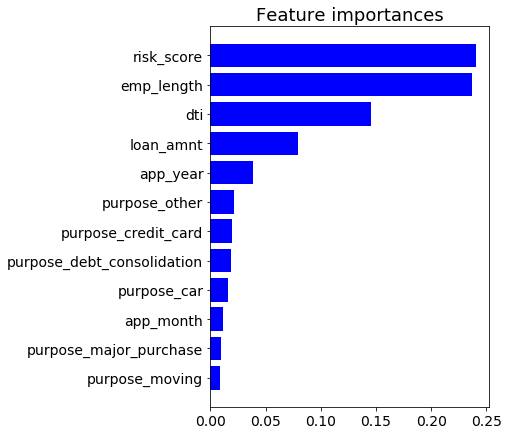

In [183]:
features = X_train.columns
importance = model.feature_importances_

indices = np.argsort(importance)[-12:]
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], importance[indices],
       color="b",  align="center")
plt.tick_params(labelsize=14);


# feature_imp = pd.Series(model.feature_importances_,index=X_train.columns).sort_values(ascending=False)
# feature_imp.head(15).plot.barh()

In [162]:
forest = RandomForestRegressor(n_jobs=2)

# Number of trees in random forest
n_estimators = [300, 400, 500, 600, 700, 800]
# Number of features to consider at every split
max_features = [2, 3, 4, 5, 6, 7]
# Maximum number of levels in tree
max_depth = [20, 22, 24]
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
              'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

forest_grid = RandomizedSearchCV(forest, param_distributions= random_grid, 
                                 cv = 5, scoring= 'neg_mean_squared_error')

forest_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=2, oob_score=False,
                                                   random_state=...o

In [179]:
forest_grid_predictions =forest_grid.best_estimator_.predict(X_test)

In [ ]:
confusion_matrix(y_test, forest_grid_predictions)

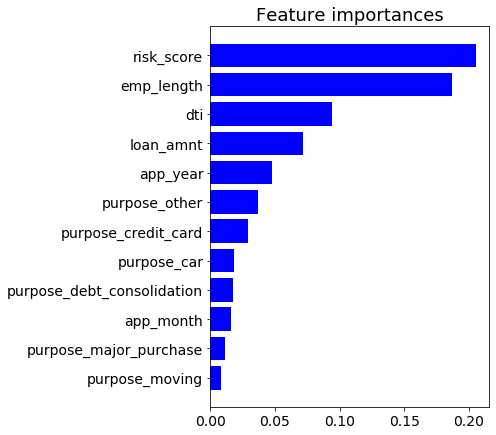

In [184]:
features = X_train.columns
importance = forest_grid.best_estimator_.feature_importances_
indices = np.argsort(importance)[-12:]
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], importance[indices],
       color="b",  align="center")
plt.tick_params(labelsize=14)

 <p><a name="svm"></a></p>
 
 ### SVM

In [148]:
svc = LinearSVC()
svc.fit(X_train, y_train)

C:\Users\miazh_000\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [149]:
y_pred_svc = svc.predict(X_test)

In [150]:
confusion_matrix(y_test, y_pred_svc)

array([[314, 273],
       [  5, 608]], dtype=int64)

 <p><a name="xgboost"></a></p>
 
 ### XGBoost

In [187]:
import xgboost as xgb

In [189]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

C:\Users\miazh_000\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [190]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 2} 

steps = 20  # The number of training iterations

In [191]:
model = xgb.train(param, D_train, steps)

In [194]:
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.9417666048454144
Recall = 0.941530885332281
Accuracy = 0.9416666666666667


In [ ]:
clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(X_train, y_train)

In [ ]:
preds = grid.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))